In [1]:
import os

import ipywidgets as widgets
import numpy as np
import pandas as pd
import scipy.sparse
from IPython.display import display
from ipywidgets import interact
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

# Data preparation

First split the orig_dataset into train and test set, then we need to
pre-process the transcript data

This includes, cleaning text, stemming and lemmatization

In [173]:
from prepare_data import prepare_original_data

# YOU MAY NEED TO SET THE LOCATION OF THE DATASET IN oneinamillion/resources.py.
orig_dataset, mult_lbl_enc, y_hot = prepare_original_data()

The current IDs only have record documents.
['011119' '020105' '030311' '030501' '030509' '030510' '050609' '050717'
 '050719' '071010' '071201' '071202' '071203' '071204' '071205' '071206'
 '071207' '071208' '071209' '071210' '071211' '071212' '071213' '071214'
 '081310' '081608' '081610' '091410' '091411' '091416' '101705' '101707'
 '111906' '111908' '112004' '122110']
The current IDs only have transcript documents.
['-081308' '010103' '010105' '020107' '030501(p.2)' '030501(p1)'
 '030509(p.1)' '030509(p.2)' '030510 (p.1)' '030510 (p.2)' '040417'
 '050605' '050609a' '050717 (Dr reads wrong number)' '060806' '060811'
 '060812' '060906' '071002' '071010(a)' '071012' '081310(b)' '081310(c)'
 '081310a' '081601' '081606' '081608 (1 of 2)' '081608 (2 of 2)' '091402'
 '091404' '091405' '091410 & 091411' '091503' '101705 and 101707' '101801'
 '111906 (2of2)' '111906(1 of 2)' '112002' '112004 & 1112005' '112014'
 '200105' '50719']


RDSF base directory located at /Volumes/NLP_One_In_A_Million
16 classification categories: ['A' 'B' 'D' 'F' 'H' 'K' 'L' 'N' 'P' 'R' 'S' 'T' 'U' 'W' 'X' 'Y']


## Train test Split

In [3]:
from skmultilearn.model_selection import iterative_train_test_split

X = np.arange(orig_dataset['index'].shape[0]).reshape((-1, 1))

X_train, y_train, X_test, y_test = iterative_train_test_split(X, y_hot, test_size=0.2)

train_set = orig_dataset.iloc[X_train.flatten()]
test_set = orig_dataset.iloc[X_test.flatten()]
train_set.head()

,index,record_id,icpc_codes,pt_records,transcript__start_date,transcript__duration,transcript__conversation,codes,transcript__conversation_clean,transcript__conversation_both,transcript__conversation_gp,transcript__conversation_patient
0,0,10112,"['K85', 'P76']","[{'date': datetime.datetime(2014, 8, 13, 0, 0)...",2014-06-16 10:33:28,0:16:17,"[('GP', 'How are you sir?'), ('Patient', ""I'm ...","[K, P]","[[GP, sir?], [Patient, i'm bad moment actually...","sir? i'm bad moment actually. right, okay good...","sir? right, okay good. prednisolone. okay. yes...",i'm bad moment actually. thought i'd come touc...
5,5,101708,"['K84', 'Y08']","[{'date': datetime.datetime(2015, 4, 24, 0, 0)...",2015-02-24 12:39:49,0:18:49,"[('PAT', 'He was supposed to come in and take ...","[K, Y]","[[PAT, supposed come take ___], [info, 0:00:01...","supposed come take ___ , ___. yes, that's alri...","yes, that's alright you. seat. patient 101708....","supposed come take ___ , ___. okay. reason i'v..."
8,8,111911,"['B80', 'D18']","[{'date': datetime.datetime(2015, 7, 21, 0, 0)...",2015-04-28 10:48:20,0:11:01,"[('DOC', 'Hi, I am Doctor Name thanks for wait...","[B, D]","[[DOC, hi, doctor name thanks waiting. doing, ...","hi, doctor name thanks waiting. doing, help? a...","hi, doctor name thanks waiting. doing, help? o...",alright thank you. last friday went give blood...
9,9,11105,['L05'],"[{'date': datetime.datetime(2015, 2, 23, 0, 0)...",2014-12-08 10:50:34,0:09:09,"[('Doc', ""Good morning, I'm Dr Name. 011105, w...",[L],"[[Doc, good morning, i'm dr name. 011105, well...","good morning, i'm dr name. 011105, well done, ...","good morning, i'm dr name. 011105, well done, ...","pardon? think have, no. well, started saturday..."
11,11,91510,"['K86', 'R96']","[{'date': datetime.datetime(2015, 3, 27, 0, 0)...",2015-01-14 16:45:30,0:07:22,"[('DOC', ""Turn this on. That's it. Number 0915...","[K, R]","[[DOC, turn on. that's it. number 091510. that...",turn on. that's it. number 091510. that's you....,turn on. that's it. number 091510. that's you....,bad. went southmead last week get result test ...


## ICPC descriptions

In [4]:
selected_mode = None
modes = ['ICPC only', 'CKS only', 'ICPC and CKS']
def control_description(mode=modes[0]):
    global selected_mode
    selected_mode = mode

interact(control_description, mode=modes)

interactive(children=(Dropdown(description='mode', options=('ICPC only', 'CKS only', 'ICPC and CKS'), value='I…

<function __main__.control_description(mode='ICPC only')>

In [5]:
selected_mode

'ICPC only'

In [6]:
from prepare_data import load_descriptions
description_corpus = load_descriptions(selected_mode, mult_lbl_enc)

## Bag of words classifiers

**Tf-idf from ICPC codes**

- extract keyword/ keyphrases from ICPC code descriptions
 - use three columns (inclusion/ preferred and criteria)

- OR, with TF-iDF, assign a score to every word (or bigram) in the utterance,
filter those with only high scores

- For each utterance in a transcript, count the number of keyword or phrase matches for each ICPC code.
- If number of matches > threshold, assign ICPC code

One might want to modify the list of stopwords to eliminate from the tf-idf vocabulary,
or might impose a limit of the number of features to reduce unwanted words/ bi-grams.

In [ ]:
from utils.stopwords import get_medical_stopwords, get_custom_stopwords, get_english_stopwords
medical_stopwords = get_medical_stopwords()
custom_stopwords = get_custom_stopwords()
english_stopwords = get_english_stopwords()

use_med, use_cus, use_eng = False, False, False
stopwords = []

def update_stopwords():
    global stopwords
    stopwords = []
    if use_med:
        stopwords += medical_stopwords
    if use_cus:
        stopwords += custom_stopwords
    if use_eng:
        stopwords += english_stopwords
    # display(f"number of stopwords: {len(stopwords)}")

def set_stopwords(m,c,e):
    global use_med, use_cus, use_eng
    use_med = m
    use_cus = c
    use_eng = e
    update_stopwords()

interact(set_stopwords, m=True, c=True, e=False)

interactive(children=(Checkbox(value=True, description='m'), Checkbox(value=True, description='c'), Checkbox(v…

<function __main__.set_stopwords(m, c, e)>

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_description_vectors(description_corpus, stopwords):
    max_features=5000

    text_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords, max_features=max_features)
    description_vec = text_vectorizer.fit_transform(description_corpus)
    # print(f"icpc description bag-of-word matrix shape: {description_vec.shape}")
    vec_vocab = text_vectorizer.vocabulary_ # dictionary that contain the BOW tokens

    # print(f"bag-of-word tokens: {', '.join(list(vec_vocab.keys())[:5])}...")
    # print(f"vocabulary size: {len(vec_vocab)}")

    return description_vec, text_vectorizer

description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)

Text(0.5, 1.0, 'bag-of-words Vector')

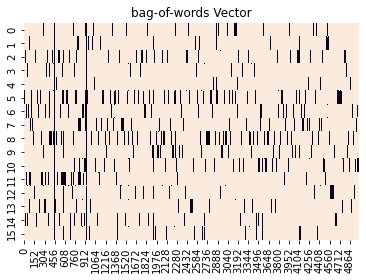

In [9]:
import seaborn as sns
sns.heatmap(description_vec.todense()==0, vmin=0, vmax=1, cbar=False).set_title('bag-of-words Vector')

In [10]:
# from wordcloud import WordCloud
# test_vec = description_vec[1].todense()
# col_names = np.array(text_vectorizer.get_feature_names())
# test = pd.DataFrame(test_vec, columns=col_names).T.to_dict()[0]
# print(test)
# word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
# plt.imshow(word_cloud)

In [11]:
from wordcloud import WordCloud

# Explain a category

lookup = [x for _,x in sorted(zip(text_vectorizer.vocabulary_.values(), text_vectorizer.vocabulary_.keys()))]
features_arr = np.array(text_vectorizer.get_feature_names())

def explain_bow_vector(vec: scipy.sparse.csr.csr_matrix, ax=plt):
    # _, idxs = scipy.sparse.csr_matrix.nonzero(vec)
    # words = [lookup[k] for k in idxs]
    # word_cloud = WordCloud().generate(' '.join(words))
    test = pd.DataFrame(vec.todense(), columns=features_arr).T.to_dict()[0]
    word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis("off")

def explain_category(cat:str, ax=plt):
    target = list(mult_lbl_enc.classes_).index(cat)
    target = description_vec[target]
    explain_bow_vector(target, ax=ax)

def plot_explain_category(cat:str):
    explain_category(cat)

interact(plot_explain_category, cat=mult_lbl_enc.classes_)

interactive(children=(Dropdown(description='cat', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', '…

<function __main__.plot_explain_category(cat: str)>

In [12]:
key = 'transcript__conversation_both'
# key = 'transcript__conversation_gp'
# key = 'transcript__conversation_patient'

X_train = text_vectorizer.transform(train_set[key])
X_test = text_vectorizer.transform(test_set[key])

Text(0.5, 1.0, 'Train set bag-of-words matrix')

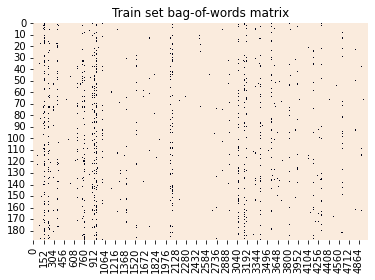

In [13]:
# import seaborn as sns
sns.heatmap(X_train.todense()==0, vmin=0, vmax=1, cbar=False).set_title('Train set bag-of-words matrix')

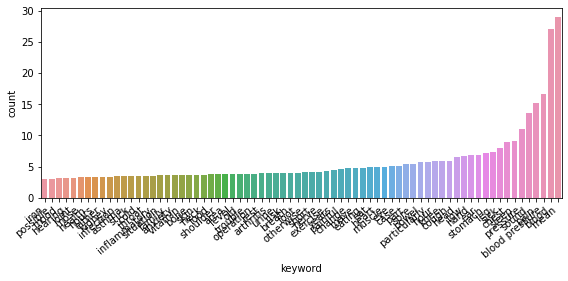

['iron', 'possible', 'mood', 'hearing', 'joint', 'nose', 'health', 'hours', 'either', 'kidney', 'infection', 'asthma', 'stick', 'cold', 'throat', 'inflammatory', 'situation', 'family', 'anxiety', 'vitamin', 'bone', 'skin', 'neck', 'food', 'shoulder', 'area', 'level', 'old', 'trouble', 'operation', 'rest', 'arthritis', 'urine', 'risk', 'breath', 'foot', 'otherwise', 'short', 'nerve', 'exercise', 'years', 'painful', 'change', 'move', 'eating', 'eat', 'heart', 'muscle', 'eye', 'case', 'part', 'sore', 'bowel', 'particularly', 'hour', 'knee', 'cough', 'head', 'low', 'hand', 'ear', 'stomach', 'leg', 'sick', 'chest', 'sleep', 'pressure', 'sound', 'pain', 'blood pressure', 'blood', 'mean']


In [14]:
keyword_dist_over_train = np.array(X_train.sum(axis=0)).flatten()

def show_common_keywords(threshold:int = 3):
    frequent_words = [[k,n] for k,n in zip(lookup, keyword_dist_over_train) if n > threshold]
    frequent_words_df = pd.DataFrame(frequent_words,columns=['keyword', 'count']).sort_values('count')

    plt.figure(figsize=(8,4))
    ax = sns.barplot(x='keyword', y='count', data=frequent_words_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

    print([k._text for k in ax.get_xticklabels()])

show_common_keywords()

In [15]:
from sklearn.metrics import classification_report, f1_score, multilabel_confusion_matrix, roc_auc_score

def evaluate_classifications(targets, predictions, class_names, show_report=False):
    """
    Evaluates the discrete classification labels.
    :param targets: A matrix where each row is a one-hot representation of the gold labels for the sample.
    :param predictions: A matrix where each row is a one-hot representation of the predicted labels for the sample.
    :param class_names: The names of the classes in an ordered list.
    :return:
    """

    keepclasses = np.any(targets, axis=0)
    targets = targets[:, keepclasses]
    predictions = predictions[:, keepclasses]

    if show_report:
        print(f"classification_report:\n{classification_report(targets, predictions, target_names=class_names, zero_division=0)}")

    return f1_score(targets, predictions, average='macro')


def evaluate_probabilities(targets, predictions):
    """
    Evaluates the probabilities output by a classifier using the ROC curve.
    :param targets: A matrix where each row is a one-hot representation of the gold labels for the sample.
    :param predictions: A matrix where each row is a one-hot representation of the predicted labels for the sample.
    :return:
    """

    keepclasses = np.any(targets, axis=0)
    targets = targets[:, keepclasses]
    predictions = predictions[:, keepclasses]

    auroc = roc_auc_score(targets, predictions, average='macro') # [:, keepclasses], predictions[:, keepclasses])
    # print(f'area under ROC curve: {auroc}')

    return auroc

### Nearest Centroid classifier

In [82]:
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier


def run_nearest_centroid(description_vec, mult_lbl_enc, X_test):
    nc_clf = NearestCentroid(metric='euclidean')
    nc_clf.fit(description_vec, mult_lbl_enc.classes_)
    y_pred = nc_clf.predict(X_test)

    y_pred_mat = np.matrix(mult_lbl_enc.transform(y_pred))

    return y_pred_mat

y_pred_mat = run_nearest_centroid(description_vec, mult_lbl_enc, X_train)
print(evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_))

def run_distance_classifier(description_vec, X_train, y_train, X_test):

    kn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine')
    kn_clf.fit(description_vec, mult_lbl_enc.classes_)

    max_acc = 0
    threshold = 0.8
    best_threshold = 0
    while threshold <= 1:
        y_dists, y_pred = kn_clf.kneighbors(X_train, 3)
        y_tr_pred = np.zeros((X_train.shape[0], y_train.shape[1]))
        for i in range(y_tr_pred.shape[0]):
            y_tr_pred[i, y_pred[i]] = (y_dists[i] < threshold).astype(int)

        acc = f1_score(y_train, y_tr_pred, average='micro')
        # print(f'F1: {acc}, threshold: {threshold}')

        if acc > max_acc:
            max_acc = acc
            best_threshold = threshold
        threshold += 0.01

    # print('predicting...')
    y_dists, y_pred = kn_clf.kneighbors(X_test, 3)
    y_pred_mat = np.zeros((X_test.shape[0], y_train.shape[1]))
    for i in range(y_pred.shape[0]):
        y_pred_mat[i, y_pred[i][0]] = (y_dists[i][0] < best_threshold).astype(int)

    # dists = cosine_similarity(X_train, description_vec)
    # print(dists)

    #
    # dists = cosine_similarity(X_test, description_vec)
    # y_pred_mat = dists > best_threshold

    return y_pred_mat

# y_pred_mat = run_distance_classifier(description_vec, X_train, y_train, X_train)
# evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)

0.3660179021020698


In [83]:
def get_idxes_with_cat(_y_train: np.ndarray, code:str):
    y_train_raw = mult_lbl_enc.inverse_transform(_y_train)
    return [i for i,cs in enumerate(y_train_raw) if code in cs]

def get_truth_pred_pairs(_y_train, _y_pred, indices):
    truth = mult_lbl_enc.inverse_transform(_y_train[indices])
    pred = _y_pred[indices]
    data = list(zip(indices, truth, pred))
    return pd.DataFrame(data, columns=['id', 'truth', 'predicted'])

def show_truth_pred_tbl(code):
    cat_idxes = get_idxes_with_cat(y_train, code)
    return get_truth_pred_pairs(y_train, y_pred_mat, cat_idxes)

interact(show_truth_pred_tbl, code=mult_lbl_enc.classes_)

interactive(children=(Dropdown(description='code', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', …

<function __main__.show_truth_pred_tbl(code)>

Seems like the baseline is not performing well on predicting classes for:

A, F, N, S, T, W, X, Y

In [93]:
from sklearn.metrics.pairwise import cosine_similarity

cat_dropdown = widgets.Dropdown(options=mult_lbl_enc.classes_)
id_dropdown = widgets.Dropdown(options=get_idxes_with_cat(y_train, cat_dropdown.value))

def refresh_id_dropdown(*args):
    id_dropdown.options = get_idxes_with_cat(y_train, cat_dropdown.value)

cat_dropdown.observe(refresh_id_dropdown, 'value')

def show_cosine_similarity(_id):
    cos_sim = cosine_similarity(X_train[_id], description_vec)[0]
    cos_sim = pd.DataFrame(list(zip(mult_lbl_enc.classes_, cos_sim)), columns=['category', 'cos sim'])
    cos_sim = cos_sim.set_index('category').T
    grid_kws = {"height_ratios": (.9, .05), "hspace": -0.5}
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
    sns.heatmap(cos_sim, square=True, ax=ax,
                cbar_ax=cbar_ax,
                cbar_kws={"orientation": "horizontal"},
                cmap='Greens')

def show_keywords_true_pred(_id, _cat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.title.set_text('BOW from sample transcipt')
    ax2.title.set_text('BOW of predicted class')
    explain_bow_vector(X_train[_id], ax=ax1)
    explain_category(_cat, ax=ax2)

def view_record(_cat, _id):
    global test
    pred_cat = mult_lbl_enc.inverse_transform(np.array(y_pred_mat)[_id:_id+1])[0][0]
    record = train_set.iloc[_id]
    info = [f"Index: {_id}",
           f"Id: {record['record_id']}",
           f"Actual: {mult_lbl_enc.inverse_transform(y_train[_id:_id+1])}",
           f"Predicted: {pred_cat}"]
    display(*info)
    show_keywords_true_pred(_id, pred_cat)
    show_cosine_similarity(_id)

interact(view_record, _cat=cat_dropdown, _id=id_dropdown)

interactive(children=(Dropdown(description='_cat', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', …

<function __main__.view_record(_cat, _id)>

In [100]:
# Note: print statements does not work in PyCharm
evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)

def plot_multilabel_conf_matrix(targets, predictions):
    print(f"multilabel_confusion_matrix:")
    conf_mat = multilabel_confusion_matrix(targets, predictions)

    for cls, mat in zip(mult_lbl_enc.classes_, conf_mat):
        fig = plt.figure(figsize=(1,1))
        ax = fig.add_subplot()
        ax.set_title(cls)
        sns.heatmap(mat, ax=ax, cmap='Blues', annot=True, fmt="d")
        ax.set_xlabel('pred')
        ax.set_ylabel('true')
        fig.show()

# plot_multilabel_conf_matrix(y_train, y_pred_mat)

For `average` parameter to take the average metrics over all classes, please see [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel).

## Binary Naive Bayes Classifier

In [101]:
from sklearn.naive_bayes import MultinomialNB

In [104]:
def run_binary_naive_bayes(X_train, y_train, X_test):
    nclasses = y_train.shape[1]

    y_pred_mat = np.zeros((X_test.shape[0], nclasses))
    y_pred_probs = np.zeros((X_test.shape[0], nclasses))

    for c in range(nclasses):
        # iterate over the classes and make a classifier for each class

        # skip classes with no test instances!
        if not np.any(y_test[:, c]):
            continue

        clf = MultinomialNB(alpha=0.001)
        clf.fit(X_train, y_train[:, c])

        y_te_pred_c = clf.predict(X_test)
        # y_pred_mat[:, c] = y_te_pred_c

        y_pred_probs[:, c] = clf.predict_proba(X_test)[:, 1]
        y_pred_mat[:, c] = y_pred_probs[:, c] > 0.1

    return y_pred_mat, y_pred_probs

y_pred_mat, y_pred_probs = run_binary_naive_bayes(X_train, y_train, X_train)  # performance on training set
print(evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_))
print(evaluate_probabilities(y_train, y_pred_probs))

0.8996624316147458
0.9686068136604249


## Multiclass Naïve Bayes Classifier

In [106]:
def run_multiclass_naive_bayes(X_train, y_train, X_test):
    clf = MultinomialNB(alpha=0.001, fit_prior=False)
    clf.fit(X_train, np.argmax(y_train, 1))

    y_pred_probs = clf.predict_proba(X_test)

    y_pred_mat = y_pred_probs > 0.1

    return y_pred_mat, y_pred_probs

y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(X_train, y_train, X_train)
evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)
evaluate_probabilities(y_train, y_pred_probs)

0.8245774213881883

## SVM Classifier

In [165]:
from sklearn.svm import SVC

def run_svm(X_train, y_train, X_test):
    nclasses = y_train.shape[1]

    clf = SVC(kernel='rbf', C=2)

    clf.fit(X_train, np.argmax(y_train, 1))

    y_pred = clf.predict(X_test)

    y_pred_mat = np.zeros((y_pred.shape[0], nclasses))
    y_pred_mat[np.arange(y_pred.shape[0]), y_pred] = 1

    return y_pred_mat

y_pred_mat = run_svm(X_train, y_train, X_train)
evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)

0.7270600612412199

In [166]:
def run_binary_svm(X_train, y_train, X_test):
    nclasses = y_train.shape[1]

    y_pred_mat = np.zeros((X_test.shape[0], nclasses))

    for c in range(nclasses):
        # iterate over the classes and make a classifier for each class

        # skip classes with no test instances!
        if not np.any(y_test[:, c]):
            continue

        clf = SVC(kernel='rbf', C=2)
        clf.fit(X_train, y_train[:, c])

        y_te_pred_c = clf.predict(X_test)
        y_pred_mat[:, c] = y_te_pred_c

    return y_pred_mat

y_pred_mat = run_binary_svm(X_train, y_train, X_train)
evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_)

0.9319308740445331

## Test Different Stopwords and Descriptions

In [171]:
def run_performance_assessment(method):
    stopword_settings = [
         [],
         ['m'],
         ['c'],
         ['e'],
         ['m', 'c'],
         ['m', 'e'],
         ['c', 'e'],
         ['m', 'c', 'e']
    ]

    description_settings = ['ICPC only', 'CKS only', 'both']

    f1_matrix = np.zeros((len(stopword_settings), len(description_settings)))
    auroc_matrix = np.zeros((len(stopword_settings), len(description_settings)))

    for j, selected_mode in enumerate(description_settings):
        description_corpus = load_descriptions(selected_mode, mult_lbl_enc)
        for i, s in enumerate(stopword_settings):
            set_stopwords('m' in s, 'c' in s, 'e' in s)
            description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)

            X_train = text_vectorizer.transform(train_set[key])

            if method == 'nearest centroid':
                y_pred_mat = run_nearest_centroid(description_vec, mult_lbl_enc, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
            elif method == 'distance':
                y_pred_mat = run_distance_classifier(description_vec, X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
            elif method == 'binary NB':
                y_pred_mat, y_pred_probs = run_binary_naive_bayes(X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
                auroc_matrix[i, j] = evaluate_probabilities(y_train, y_pred_probs)
            elif method == 'multiclass NB':
                y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
                auroc_matrix[i, j] = evaluate_probabilities(y_train, y_pred_probs)
            elif method == 'binary SVM':
                y_pred_mat = run_binary_svm(X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
            elif method == 'multiclass SVM':
                y_pred_mat = run_svm(X_train, y_train, X_train)  # performance on training set
                f1_matrix[i, j] = evaluate_classifications(y_train, y_pred_mat, mult_lbl_enc.classes_, show_report=False)

    max_idx = np.unravel_index(np.argmax(f1_matrix), f1_matrix.shape)
    best_tr_f1 = np.max(f1_matrix)
    best_stopwords = stopword_settings[max_idx[0]]
    best_desc = description_settings[max_idx[1]]
    print(f'Method: {method}. The best score on the training set was {best_tr_f1} with {best_stopwords} stopwords and {best_desc} code descriptions.')

    print('F1 score matrix for the different settings we tried:')
    print(f1_matrix)
    print(f'...rows are stopword settings, {stopword_settings}, and columns are code descriptions, {description_settings}')

    # use the best settings to run the classifier on the test set
    description_corpus = load_descriptions(selected_mode, mult_lbl_enc)
    set_stopwords('m' in s, 'c' in s, 'e' in s)
    description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)

    X_test = text_vectorizer.transform(test_set[key])


    if method == 'nearest centroid':
        y_pred_mat = run_nearest_centroid(description_vec, mult_lbl_enc, X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_mat)
    elif method == 'distance':
        y_pred_mat = run_distance_classifier(description_vec, X_train, y_train, X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_mat)
    elif method == 'binary NB':
        y_pred_mat, y_pred_probs = run_binary_naive_bayes(X_train, y_train, X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_probs)
    elif method == 'multiclass NB':
        y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(X_train, y_train, X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_probs)
    elif method == 'binary SVM':
        y_pred_mat = run_binary_svm(X_train, y_train, X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_mat)
    elif method == 'multiclass SVM':
        y_pred_mat = run_svm(X_train, y_train, X_test)  # performance on training set
        f1 = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc = evaluate_probabilities(y_test, y_pred_mat)

    print(f'Method: {method}. The F1 score on the test set was {f1}.')

    return auroc, f1, best_tr_f1, best_desc, best_stopwords


In [172]:
auroc = {}
f1scores = {}
tr_f1scores = {}
best_descriptions = {}
best_stopwords = {}

def run_and_record_metrics(classifier_name):
    auroc[classifier_name], f1scores[classifier_name], tr_f1scores[classifier_name], \
        best_descriptions[classifier_name], best_stopwords[classifier_name] \
    = run_performance_assessment(classifier_name)

classifiers_to_run = [
    'nearest centroid',
    'distance',
    'binary NB',
    'multiclass NB',
    'binary SVM', 
    'multiclass SVM'
]    

for classifier in classifiers_to_run:
    run_and_record_metrics(classifier)

Method: nearest centroid. The best score on the training set was 0.3816126701225858 with ['c', 'e'] stopwords and both code descriptions.
F1 score matrix for the different settings we tried:
[[0.31520765 0.29348166 0.31008144]
 [0.31466271 0.30640457 0.32163871]
 [0.33729835 0.33198259 0.35640173]
 [0.3351539  0.31645548 0.3458048 ]
 [0.3660179  0.33138109 0.36245326]
 [0.32854623 0.31650406 0.34077005]
 [0.36591073 0.33935224 0.38161267]
 [0.36597902 0.35665587 0.37136543]]
...rows are stopword settings, [[], ['m'], ['c'], ['e'], ['m', 'c'], ['m', 'e'], ['c', 'e'], ['m', 'c', 'e']], and columns are code descriptions, ['ICPC only', 'CKS only', 'both']
Method: nearest centroid. The F1 score on the test set was 0.5801717580664949.
Method: distance. The best score on the training set was 0.36615124885455985 with ['c', 'e'] stopwords and both code descriptions.
F1 score matrix for the different settings we tried:
[[0.31551099 0.29150394 0.28930735]
 [0.31494936 0.29517093 0.30069482]
 [0.3

It looks like there is lots of overfitting of the classifiers above, as there is high trainign set performance and low test set performance, especially when using multiple binary classifiers. 

In [ ]:
f1scores

In [ ]:
tr_f1scores

In [ ]:
best_stopwords

In [ ]:
best_descriptions

In [ ]:
auroc